In [1]:
import os
dataset_path = "Matang"
file_list = os.listdir(dataset_path)
print(file_list)

['1. k', '10. b', '11. r', '12. s', '13. ng', '14. ny', '15. n', '16. m', '17. l', '18. h', '2. c', '3. t', '4. p', '5. y', '6. w', '7. g', '8. j', '9. d']


## Data Visualization

### Organize Data and Labels

In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array

# Define image dimensions
img_height = 128  # You can change this to your preferred height
img_width = 128   # You can change this to your preferred width

# Initialize lists to hold the data and labels
image_data = []
labels = []

# Iterate through the subfolders to load images and their labels
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust extensions as necessary
                # Load image and convert to array
                img_path = os.path.join(subfolder_path, filename)
                image = load_img(img_path, target_size=(img_height, img_width))
                image = img_to_array(image)
                
                # Append image data and extract class label from filename
                image_data.append(image)
                
                # Extract the class label from the filename (e.g., ke1, ki2)
                label = filename.split('(')[0]  # This will give you 'ke' or 'ki'
                labels.append(label)

# Convert lists to NumPy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

### Visualize Distribution

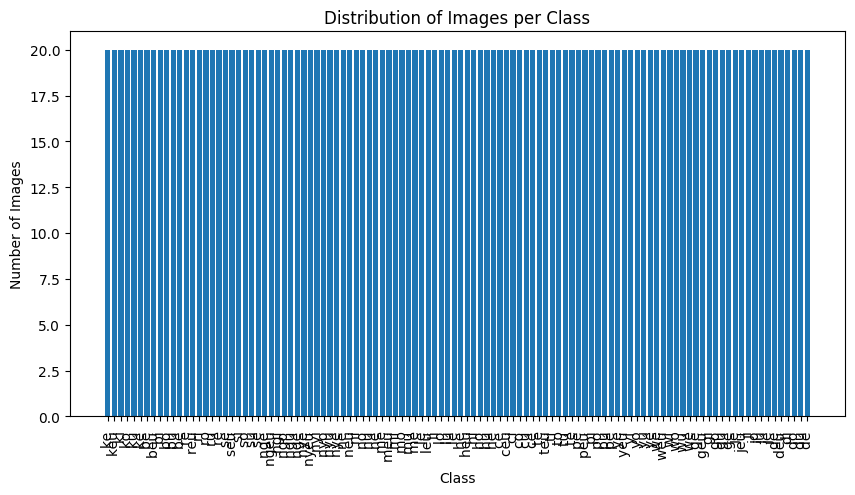

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the number of images per class
class_counts = Counter(labels)

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)  # Rotate class labels for readability
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class")
plt.show()

### Visualize Image Samples

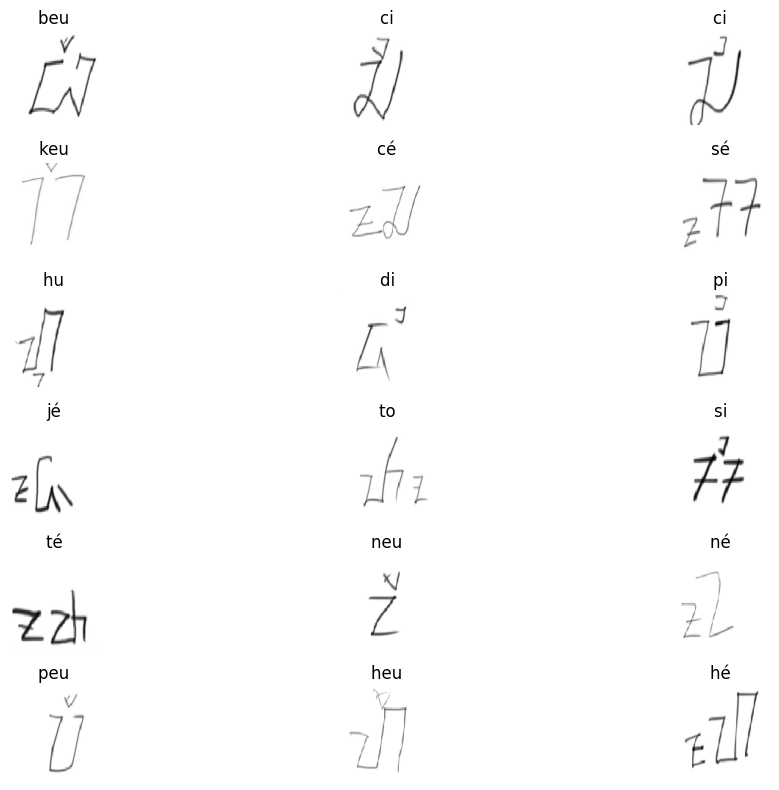

In [4]:
import matplotlib.pyplot as plt

def visualize_samples(image_data, labels, num_samples=18):
    plt.figure(figsize=(12, 8))
    
    # Randomly select indices to visualize
    indices = np.random.choice(len(image_data), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(6, 3, i + 1)  # 6 rows, 3 columns
        plt.imshow(image_data[idx].astype('uint8'))  # Convert image array to uint8 for proper visualization
        plt.title(labels[idx])  # Display the label (class)
        plt.axis('off')  # Turn off axis
    
    plt.tight_layout()
    plt.show()

# Call the function to visualize image samples
visualize_samples(image_data, labels)

## Preprocessing

### Create a seperate sharpened Dataframe

In [5]:
from PIL import Image, ImageFilter

def sharpen_images(image_data):
    sharpened_images = []
    for img in image_data:
        # Ensure the image is in uint8 format
        img = (img * 255).astype(np.uint8)  # Convert from float (if applicable) to uint8
        pil_img = Image.fromarray(img)  # Convert numpy array back to PIL image
        sharpened_img = pil_img.filter(ImageFilter.SHARPEN)  # Apply sharpening filter
        sharpened_images.append(np.array(sharpened_img))  # Convert back to numpy array
    return np.array(sharpened_images)

# Create the sharpened dataset
sharpened_image_data = sharpen_images(image_data)

# Check the number of sharpened images
print(f"Created {len(sharpened_image_data)} sharpened images.")

Created 2160 sharpened images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [80.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [23.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [19.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [105.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [128.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [113.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [71.0..255.0].
Clipping input data to the valid range for imshow wi

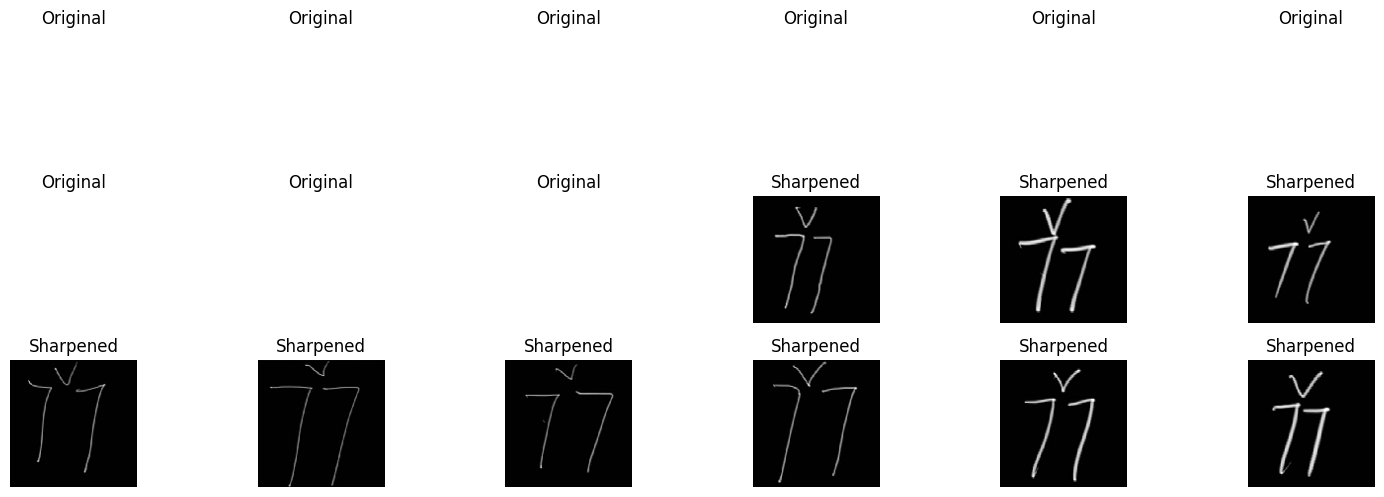

In [6]:
def compare_images(original_images, sharpened_images, num_samples=18):
    plt.figure(figsize=(15, 10))
    rows, cols = 6, 6  # 6 rows and 6 columns for comparison (3 original + 3 sharpened)
    
    for i in range(num_samples // 2):  # Half for original, half for sharpened
        # Original images
        plt.subplot(rows, cols, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis('off')

        # Sharpened images
        plt.subplot(rows, cols, i + 1 + (num_samples // 2))
        plt.imshow(sharpened_images[i])
        plt.title("Sharpened")
        plt.axis('off')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Compare the first 18 original and sharpened images
compare_images(image_data, sharpened_image_data, num_samples=18)

### Split the Data

In [7]:
from sklearn.model_selection import train_test_split

# Define a function to split datasets with customizable train, validation, and test sizes
def split_dataset(image_data, labels, train_size=0.75, val_size=0.15, test_size=0.1, random_state=42):
    """
    Splits the image data and labels into training, validation, and test sets.
    
    Parameters:
        image_data (np.array): The array of image data.
        labels (np.array): The array of corresponding labels.
        train_size (float): Proportion of the dataset to include in the training set.
        val_size (float): Proportion of the dataset to include in the validation set.
        test_size (float): Proportion of the dataset to include in the test set.
        random_state (int): Controls the shuffling applied to the data before splitting.
    
    Returns:
        tuple: (train_data, val_data, test_data), where each is a tuple of (X, y).
    """
    if not (0 < train_size < 1) or not (0 < val_size < 1) or not (0 < test_size < 1):
        raise ValueError("train_size, val_size, and test_size must be between 0 and 1")
    if train_size + val_size + test_size != 1:
        raise ValueError("train_size + val_size + test_size must equal 1")

    # Split the dataset into training and temp (validation + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        image_data, labels, train_size=train_size, stratify=labels, random_state=random_state
    )

    # Split the remaining data into validation and test sets based on the adjusted sizes
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=test_size / (val_size + test_size), stratify=y_temp, random_state=random_state
    )

    print(f"Split sizes -> Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Example usage of the function with the validation set larger than the test set
(sharpened_train, sharpened_labels_train), (sharpened_val, sharpened_labels_val), (sharpened_test, sharpened_labels_test) = split_dataset(
    sharpened_image_data, labels, train_size=0.75, val_size=0.20, test_size=0.05, random_state=42
)

# Check the sizes of the splits
print(f"Sharpened Train: {len(sharpened_train)}, Validation: {len(sharpened_val)}, Test: {len(sharpened_test)}")


Split sizes -> Train: 1620, Val: 432, Test: 108
Sharpened Train: 1620, Validation: 432, Test: 108


## Modelling

### Create a Sequential Model

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Example Sequential model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  # Adjust input shape
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model.add(Flatten())

# Fully connected layers
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))  # Regularization
model.add(Dense(len(np.unique(sharpened_train)), activation='softmax'))  # Adjust output layer

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Convert labels into Numeric

In [9]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to numeric labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Now split the datasets using the encoded labels
(original_train, original_labels_train), (original_val, original_labels_val), (original_test, original_labels_test) = split_dataset(image_data, labels_encoded)
(sharpened_train, sharpened_labels_train), (sharpened_val, sharpened_labels_val), (sharpened_test, sharpened_labels_test) = split_dataset(sharpened_image_data, labels_encoded)

Split sizes -> Train: 1620, Val: 324, Test: 216
Split sizes -> Train: 1620, Val: 324, Test: 216


## Training

### Training with Sharpened Datasets

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,              # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Verbosity mode, 1 = display messages when stopping
    mode='max',              # Mode can be 'min', 'max', or 'auto'
    restore_best_weights=True # Restore the weights of the best model when training stops
)

# Now train the model
epochs = 50
batch_size = 20

# Train the model on the sharpened dataset
history_sharpened = model.fit(
    sharpened_train,
    sharpened_labels_train,
    validation_data=(sharpened_val, sharpened_labels_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]  # Include the EarlyStopping callback

)

# Print training history for the sharpened dataset
print("Training on sharpened dataset complete!")

Epoch 1/50
81/81 [==============================] - 9s 31ms/step - loss: 6.3116 - accuracy: 0.0111 - val_loss: 4.5800 - val_accuracy: 0.0401
Epoch 2/50
81/81 [==============================] - 2s 26ms/step - loss: 4.3288 - accuracy: 0.0500 - val_loss: 3.6344 - val_accuracy: 0.1512
Epoch 3/50
81/81 [==============================] - 2s 25ms/step - loss: 3.3154 - accuracy: 0.1636 - val_loss: 2.6959 - val_accuracy: 0.2901
Epoch 4/50
81/81 [==============================] - 2s 24ms/step - loss: 2.3019 - accuracy: 0.3586 - val_loss: 2.1467 - val_accuracy: 0.3796
Epoch 5/50
81/81 [==============================] - 2s 24ms/step - loss: 1.6570 - accuracy: 0.5086 - val_loss: 1.8726 - val_accuracy: 0.4444
Epoch 6/50
81/81 [==============================] - 2s 24ms/step - loss: 1.1144 - accuracy: 0.6488 - val_loss: 1.7486 - val_accuracy: 0.5062
Epoch 7/50
81/81 [==============================] - 2s 24ms/step - loss: 0.8850 - accuracy: 0.7198 - val_loss: 1.6326 - val_accuracy: 0.5216
Epoch 8/50
81

## Visualize Results


### Accuracy and Loss

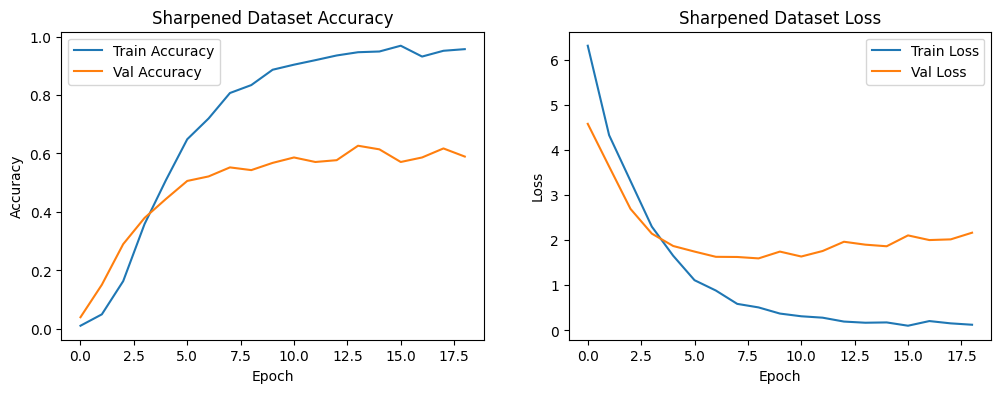

In [11]:
# Plotting accuracy for the sharpened dataset
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_sharpened.history['accuracy'], label='Train Accuracy')
plt.plot(history_sharpened.history['val_accuracy'], label='Val Accuracy')
plt.title('Sharpened Dataset Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss for the sharpened dataset
plt.subplot(1, 2, 2)
plt.plot(history_sharpened.history['loss'], label='Train Loss')
plt.plot(history_sharpened.history['val_loss'], label='Val Loss')
plt.title('Sharpened Dataset Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Confusion Matrix

In [12]:
# Make predictions on the test set
predictions = model.predict(original_test)
predicted_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

7/7 [==============================] - 1s 68ms/step


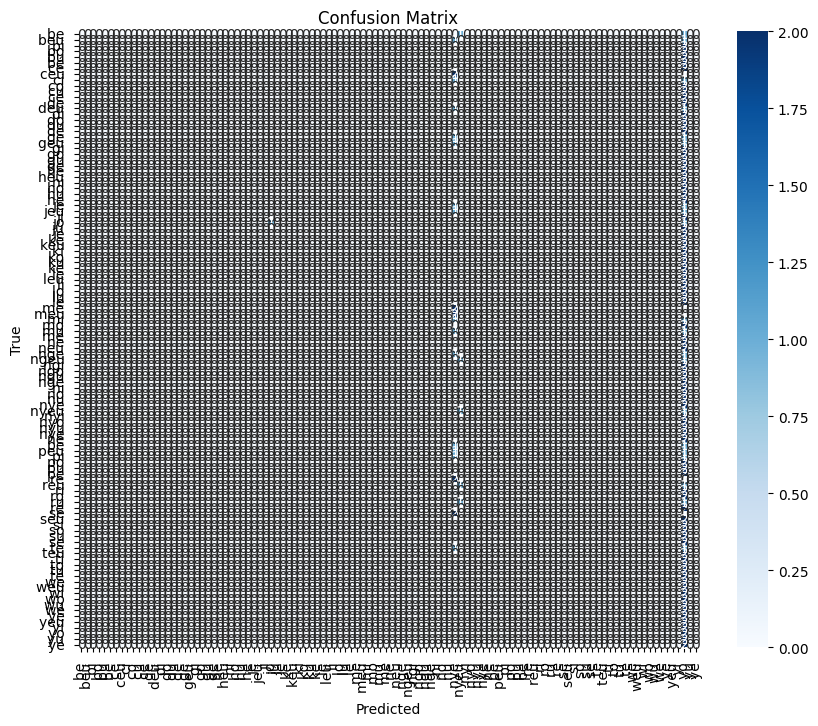

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate the confusion matrix
conf_matrix = confusion_matrix(original_labels_test, predicted_classes)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, label_encoder.classes_)